In [1]:
from function import *
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.pyplot import subplots
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random


data = pd.read_pickle('/home/jinzhuo/ww_dataset/SCMS/aplysia_ganglia/Aplysia_Data.pkl')
sample_info = pd.read_pickle('/home/jinzhuo/ww_dataset/SCMS/aplysia_ganglia/Aplysia_SampleInfo.pkl')
feature_info = pd.read_pickle('/home/jinzhuo/ww_dataset/SCMS/aplysia_ganglia/Aplysia_Features.pkl')

In [2]:
data['type'] = sample_info['types']
types = list({t for t in data['type']})
types = sorted(types)
types

import joblib
model = joblib.load('/home/jinzhuo/ww_dataset/DECOMPOSITION/model_save_file/xgboost_model.pkl')
from shap import TreeExplainer
shap_explainer = TreeExplainer(model)
shap_values = shap_explainer.shap_values(data.drop(['type'],axis =1))

shap_index = shap_index_out(20,np.array(shap_values))
print(len(shap_index))

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


46


In [3]:
cell_type_ref,data_matrix_list_trainnn,data_matrix_list_val= cell_type_ref_train(data,types,1,1501,2001,shap_index)

(4695, 46) Abdom
(1500, 46) Abdom
(2665, 46) Bag
(1500, 46) Bag
(3841, 46) Buccal
(1500, 46) Buccal
(5212, 46) Cere
(1500, 46) Cere
(12106, 46) Pedal
(1500, 46) Pedal
(3874, 46) Pleural
(1500, 46) Pleural


In [9]:
len(data_matrix_list_trainnn)

6

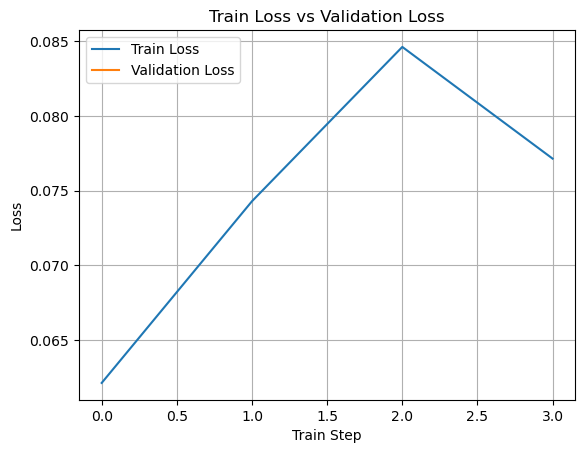

0.07356003567576408
(0.31082169381622965, 0.002628059576941038, 0.26065089985124296, 69.84208588112523, -21.148251103051134, array([ 69.84208588, -21.1482511 ]), 0.2809961108116181)
(-0.25858844320837987, -0.002484664873844209, 0.2549256433138447, -50.41624200021457, 18.698467358827113, array([-50.416242  ,  18.69846736]), 0.273014561644037)
(-0.1130984712610581, -0.0004643759272919689, 0.2624942257982145, -55.06456241688988, 18.33225122492303, array([-55.06456242,  18.33225122]), 0.26431198804111916)
100


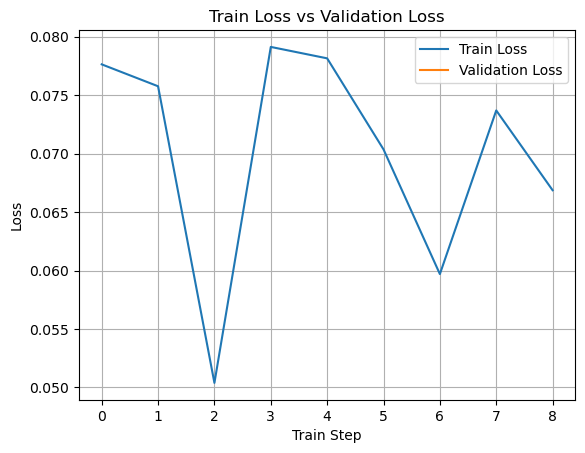

0.07578781792894006
(0.21292466227563112, 0.0019317888127692697, 0.27401986755771574, 46.67411072398125, -16.65732872700891, array([ 46.67411072, -16.65732873]), 0.28097016969289973)
(-0.23849031704571047, -0.0004861023222863246, 0.26935651649596465, -233.612219604564, 69.66457864101163, array([-233.6122196 ,   69.66457864]), 0.2776662641904741)
(0.018560586177779354, 0.00019866499360649372, 0.2681616290370266, 3.4636355895949955, -0.8253399859181564, array([ 3.46363559, -0.82533999]), 0.2683540942790143)
200


KeyboardInterrupt: 

In [4]:
import copy
for mm in range(10):
    train_cell_num = 100*(mm+1)
    data_matrix_list_train = []
    data_matrix_list_train = copy.deepcopy(data_matrix_list_trainnn)
    for i in range(len(data_matrix_list_train)):
        data_matrix_list_train[i] = data_matrix_list_train[i][:train_cell_num,]
    train_step = 1000
    # 创建模型实例
    input_size = len(shap_index) # 根据你的输入数据大小设置
    hidden_units = [256, 128, 64, 32]  # 根据你的隐藏层单元设置
    do_rates = [0,0,0,0]  # 根据你的dropout率设置
    n_classes = 3 # 根据你的类别数设置
    model_dnn = 0
    model_dnn = YourModel(input_size, hidden_units, do_rates, n_classes)

    loss_train_plt = []
    loss_val_plt = []
    loss_min = 1000
    min_sample_trian = []
    min_sample_val = []
    LEARNING_RATE = 0.001
    lossmse = nn.MSELoss()
    optimizer = Adam(model_dnn.parameters(), lr=LEARNING_RATE)
    for i in range(train_step):
        model_dnn.train()
        input,target = batch_data(32,input_size,data_matrix_list_train)
        output = model_dnn(input)
        output = output.reshape(target.shape)
        loss = lossmse(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train_plt.append(loss.item())
        # print("loss",loss)
        # print(target[0],output[0],loss.item())
        # print(loss)
        if i%10==0:
            model_dnn.eval()
            loss_val = 0
            for j in range(100):
                input,target = batch_data(8,input_size,data_matrix_list_val)
                output = model_dnn(input)
                output = output.reshape(target.shape)
                loss = lossmse(output,target)
                loss_val = loss_val+loss.item()
            loss_val = loss_val/100
            loss_val_plt.append(loss_val)
            # print(i,loss_val)
            if loss_val < loss_min:
                loss_min = loss_val
                min_sample_trian = []
                min_sample_val = []
                for k in range(25):
                    input,target = batch_data(8,input_size,data_matrix_list_val)
                    output = model_dnn(input)
                    output = output.reshape(target.shape)
                    min_sample_val.append([output,target,i])

                    input,target = batch_data(8,input_size,data_matrix_list_train)
                    output = model_dnn(input)
                    output = output.reshape(target.shape)
                    min_sample_trian.append([output,target,i])

    train_steps = [i for i in range(len(loss_train_plt))]
    val_steps = [i*10 for i in range(len(loss_val_plt))]
    plt.plot(train_steps, loss_train_plt, label='Train Loss', linestyle='-')
    plt.plot(val_steps, loss_val_plt, label='Validation Loss', linestyle='-')
    plt.legend()
    plt.xlabel('Train Step')
    plt.ylabel('Loss')
    plt.title('Train Loss vs Validation Loss')
    plt.grid(True)
    # plt.savefig(f"/home/jinzhuo/ww_dataset/DECOMPOSITION/non-linear/svg/{train_cell_num}.svg",format = 'svg',dpi = 300)
    plt.show()

    output_list = []
    target_list = []
    cell_type_num = 3
    for j in range(cell_type_num):
        for i in range(len(min_sample_val)):
            output,target,_ = min_sample_val[i]
            output_list.extend(output[:,j].tolist())
            target_list.extend(target[:,j].tolist())
    print(loss_min)
    print(caculate_metrics(output_list[0:200],target_list[0:200]))
    print(caculate_metrics(output_list[200:400],target_list[200:400]))
    print(caculate_metrics(output_list[400:600],target_list[400:600]))
    print(train_cell_num)

In [10]:
train_cell_num = 100
for i in range(len(data_matrix_list_train)):
    data_matrix_list_train[i] = data_matrix_list_train[i][:train_cell_num,]
train_step = 1000
# 创建模型实例
input_size = len(shap_index) # 根据你的输入数据大小设置
hidden_units = [256, 128, 64, 32]  # 根据你的隐藏层单元设置
do_rates = [0,0,0,0]  # 根据你的dropout率设置
n_classes = 3 # 根据你的类别数设置
model_dnn = 0
model_dnn = YourModel(input_size, hidden_units, do_rates, n_classes)

In [11]:
loss_train_plt = []
loss_val_plt = []
loss_min = 1000
min_sample_trian = []
min_sample_val = []
LEARNING_RATE = 0.001
lossmse = nn.MSELoss()
optimizer = Adam(model_dnn.parameters(), lr=LEARNING_RATE)
for i in range(train_step):
    model_dnn.train()
    input,target = batch_data(32,input_size,data_matrix_list_train)
    output = model_dnn(input)
    output = output.reshape(target.shape)
    loss = lossmse(output,target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train_plt.append(loss.item())
    # print("loss",loss)
    # print(target[0],output[0],loss.item())
    # print(loss)
    if i%10==0:
        model_dnn.eval()
        loss_val = 0
        for j in range(100):
            input,target = batch_data(8,input_size,data_matrix_list_val)
            output = model_dnn(input)
            output = output.reshape(target.shape)
            loss = lossmse(output,target)
            loss_val = loss_val+loss.item()
        loss_val = loss_val/100
        loss_val_plt.append(loss_val)
        # print(i,loss_val)
        if loss_val < loss_min:
            loss_min = loss_val
            min_sample_trian = []
            min_sample_val = []
            for k in range(25):
                input,target = batch_data(8,input_size,data_matrix_list_val)
                output = model_dnn(input)
                output = output.reshape(target.shape)
                min_sample_val.append([output,target,i])

                input,target = batch_data(8,input_size,data_matrix_list_train)
                output = model_dnn(input)
                output = output.reshape(target.shape)
                min_sample_trian.append([output,target,i])


train_steps = [i for i in range(len(loss_train_plt))]
val_steps = [i*10 for i in range(len(loss_val_plt))]
plt.plot(train_steps, loss_train_plt, label='Train Loss', linestyle='-')
plt.plot(val_steps, loss_val_plt, label='Validation Loss', linestyle='-')
plt.legend()
plt.xlabel('Train Step')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.grid(True)
plt.savefig(f"/home/jinzhuo/ww_dataset/DECOMPOSITION/non-linear/svg/{train_cell_num}.svg",format = 'svg',dpi = 300)
plt.show()

output_list = []
target_list = []
cell_type_num = 3
for j in range(cell_type_num):
    for i in range(len(min_sample_val)):
        output,target,_ = min_sample_val[i]
        output_list.extend(output[:,j].tolist())
        target_list.extend(target[:,j].tolist())
print(caculate_metrics(output_list[0:200],target_list[0:200]))
print(caculate_metrics(output_list[200:400],target_list[200:400]))
print(caculate_metrics(output_list[400:600],target_list[400:600]))
print(loss_min)

KeyboardInterrupt: 